#  VGG11-0.5 Uncertainty estimation using Hierarchical BN.

__Setup__: train net with vanilla BN, simultaniusly train variation approximation $r(\mu), r(\sigma)$, using exponential smoothed statistics. Dataset -- CIFAR5 (...), uncertainty estimation on the rest 5 classes.


### Models

__BN__ -- net with vanilla batchnorm, stochasticity induced by choicing batch.

__HBN__ -- net trained with vanilla BN as well with updating parameters for approximation $r(\mu), r(\sigma)$.

__HBN-T__ -- the same as HBN plus tuning params of $r(\mu), r(\sigma)$ (by sampling from them on each layer in a decorrelated way) with fixed NN weights.

In [18]:
ckpt = torch.load('vgg-exps/cifar5/bn-my/bs32/tuned_model')

In [21]:
ckpt['script_args']

{'augmentation': True,
 'bn_mode': 'StochBN',
 'bs': 32,
 'data': 'cifar5',
 'decay': None,
 'decrease_from': 1,
 'dropout': None,
 'epochs': 200,
 'finetune_bn': False,
 'k': 0.5,
 'log_dir': 'vgg-exps/cifar5/bn-my/bs32',
 'log_grads': False,
 'log_n_epochs': 10,
 'log_snr': False,
 'lr': 0.001,
 'mean_strategy': 'batch',
 'model': 'VGG11',
 'n_classes': 5,
 'noiid': False,
 'resume': False,
 'sample_policy': 'one',
 'sample_stats_from': 1,
 'sample_w_init': 0.0,
 'sample_w_iter': None,
 'script': 'train-with-logs.py',
 'start_tmode': None,
 'update_policy': 'after',
 'var_strategy': 'batch',
 'weight_decay': 0.0}

In [2]:
%env CUDA_VISIBLE_DEVICES=0
import torch
from StochBN import utils
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import numpy as np

%matplotlib inline

env: CUDA_VISIBLE_DEVICES=0


In [9]:
bs_grid = [128, 8]
# hbn_res = {}

cifar5_train, cifar5_test = utils.get_dataloader(data='cifar5', test_bs=500)
cifar5rest_train, cifar5rest_test = utils.get_dataloader(data='cifar5-rest', test_bs=500)

for bs in bs_grid:
    hbn_net = utils.load_model('vgg-exps/cifar5/bn-my/bs{}/tuned_model'.format(bs))
    utils.set_bn_mode(hbn_net, 'StochBN')
    hbn_net.eval()
    hbn_res[bs] = utils.uncertainty_acc(hbn_net, known=cifar5_test, unknown=cifar5rest_test)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [24]:
# LOGS
#torch.save(hbn_res, 'StochBN/results/cifar5/uncertainty/vgg11-0.5/hbn-t_unc-acc')

In [25]:
bs_grid = [4, 8, 16, 32, 128]
bn_res = {}

cifar5_train, cifar5_test = utils.get_dataloader(data='cifar5', test_bs=500)
cifar5rest_train, cifar5rest_test = utils.get_dataloader(data='cifar5-rest', test_bs=500)

for bs in bs_grid:
    bn_net = utils.load_model('vgg-exps/cifar5/bn-my/bs{}/model'.format(bs))
    utils.set_bn_mode(bn_net, 'StochBN')
    bn_net.eval()
    bn_res[bs] = utils.uncertainty_acc(bn_net, cifar5_test, cifar5rest_test, bs=bs, bn_type='BN',
                                       vanilla_known=(cifar5_test.dataset.test_data, cifar5_test.dataset.test_labels),
                                       vanilla_unknown=(cifar5rest_test.dataset.test_data, cifar5rest_test.dataset.test_labels))
    
# LOGS
torch.save(bn_res, 'StochBN/results/cifar5/uncertainty/vgg11-0.5/bn_unc-acc')

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [26]:
torch.save(bn_res, 'StochBN/results/cifar5/uncertainty/vgg11-0.5/bn_unc-acc')

In [27]:
bs_grid = [4, 8, 16, 32, 128]
rbn_res = {}

cifar5_train, cifar5_test = utils.get_dataloader(data='cifar5', test_bs=500)
cifar5rest_train, cifar5rest_test = utils.get_dataloader(data='cifar5-rest', test_bs=500)

for bs in bs_grid:
    bn_net = utils.load_model('vgg-exps/cifar5/bn-my/bs{}/model'.format(bs))
    utils.set_bn_mode(bn_net, 'StochBN')
    bn_net.eval()
    rbn_res[bs] = utils.uncertainty_acc(bn_net, cifar5_test, cifar5rest_test, bs=bs)
torch.save(rbn_res, 'StochBN/results/cifar5/uncertainty/vgg11-0.5/hbn_unc-acc')

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


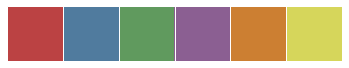

In [3]:
colors = sns.color_palette('Set1', desat=.6)
sns.palplot(colors)

## Accuracy

In [30]:
for bs in bs_grid[1:]:
    print('\nbatch size {}'.format(bs))
    print('  EVAL   -- BN {:.3f}, HBN {:.3f}, HBN-T {:.3f}'.format(bn_res[bs][1]['eval/acc'],
                                                                   rbn_res[bs][1]['eval/acc'],
                                                                   hbn_res[bs][1]['eval/acc']))

    print('ENSEMBLE -- BN {:.3f}, HBN {:.3f}, HBN-T {:.3f}'.format(bn_res[bs][1]['ensemble/acc'],
                                                                   rbn_res[bs][1]['ensemble/acc'],
                                                                   hbn_res[bs][1]['ensemble/acc']))
    
    print('ONE SHOT -- BN {:.3f}, HBN {:.3f}, HBN-T {:.3f}'.format(bn_res[bs][1]['one_shot/acc'],
                                                                   rbn_res[bs][1]['one_shot/acc'],
                                                                   hbn_res[bs][1]['one_shot/acc']))


batch size 8
  EVAL   -- BN 0.935, HBN 0.935, HBN-T 0.929
ENSEMBLE -- BN 0.935, HBN 0.935, HBN-T 0.931
ONE SHOT -- BN 0.931, HBN 0.920, HBN-T 0.864

batch size 16
  EVAL   -- BN 0.934, HBN 0.934, HBN-T 0.932
ENSEMBLE -- BN 0.932, HBN 0.935, HBN-T 0.931
ONE SHOT -- BN 0.928, HBN 0.927, HBN-T 0.899

batch size 32
  EVAL   -- BN 0.929, HBN 0.929, HBN-T 0.928
ENSEMBLE -- BN 0.932, HBN 0.930, HBN-T 0.927
ONE SHOT -- BN 0.929, HBN 0.926, HBN-T 0.912

batch size 128
  EVAL   -- BN 0.931, HBN 0.931, HBN-T 0.929
ENSEMBLE -- BN 0.931, HBN 0.931, HBN-T 0.929
ONE SHOT -- BN 0.929, HBN 0.932, HBN-T 0.929


## Unsertainty estimation

### HBN-Tuned 

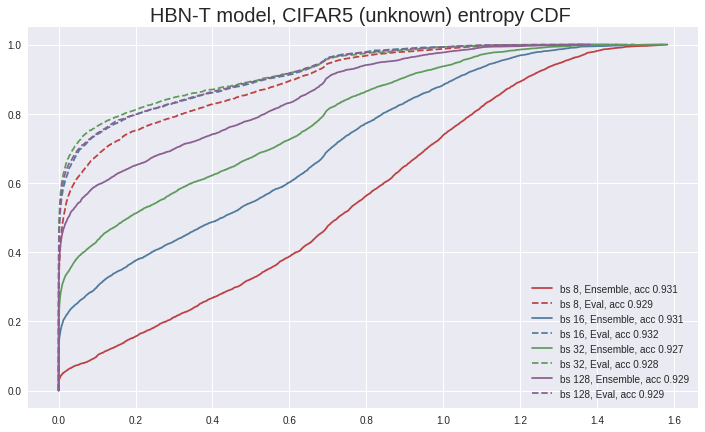

In [34]:
plt.figure(figsize=(12, 7))
plt.title('HBN-T model, CIFAR5 (unknown) entropy CDF ', size=20)
for bs, c in zip(sorted(hbn_res.keys()), colors):
    res = hbn_res[bs]
    ent = res[0]['ensemble/entropy']
    n = len(ent)
    plt.plot(sorted(ent), (np.arange(n) + 1.) / n, ls='-', c=c, label='bs {}, Ensemble, acc {:.3f}'.format(bs, res[1]['ensemble/acc']))

    ent = res[0]['eval/entropy']
    n = len(ent)
    plt.plot(sorted(ent), (np.arange(n) + 1.) / n, ls='--', c=c, label='bs {}, Eval, acc {:.3f}'.format(bs, res[1]['eval/acc']))

plt.legend()

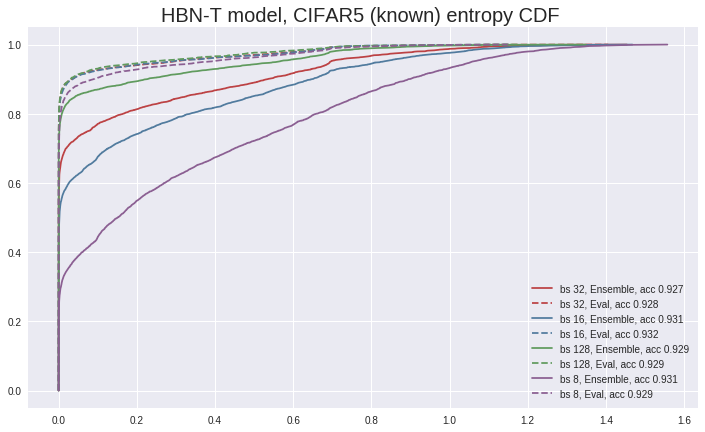

In [16]:
plt.figure(figsize=(12, 7))
plt.title('HBN-T model, CIFAR5 (known) entropy CDF ', size=20)
for [bs, res], c in zip(hbn_res.iteritems(), colors):
    ent = res[1]['ensemble/entropy']
    n = len(ent)
    plt.plot(sorted(ent), (np.arange(n) + 1.) / n, ls='-', c=c, label='bs {}, Ensemble, acc {:.3f}'.format(bs, res[1]['ensemble/acc']))

    ent = res[1]['eval/entropy']
    n = len(ent)
    plt.plot(sorted(ent), (np.arange(n) + 1.) / n, ls='--', c=c, label='bs {}, Eval, acc {:.3f}'.format(bs, res[1]['eval/acc']))

plt.legend()

### HBN

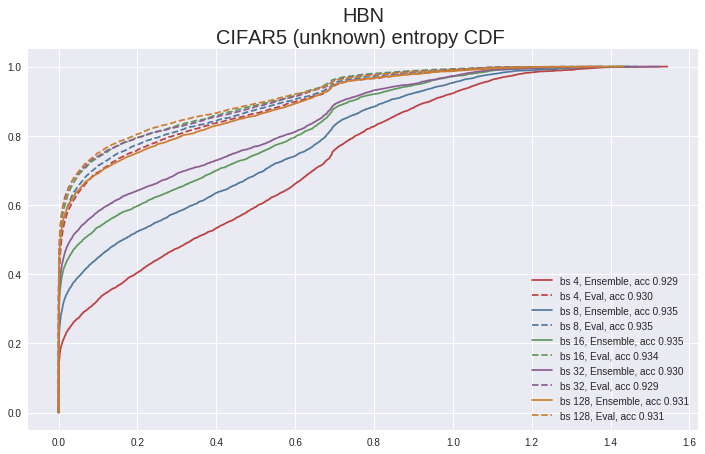

In [37]:
plt.figure(figsize=(12, 7))
plt.title('HBN\nCIFAR5 (unknown) entropy CDF ', size=20)
for bs, c in zip(sorted(rbn_res.keys()), colors):
    res = rbn_res[bs]
    ent = res[0]['ensemble/entropy']
    n = len(ent)
    plt.plot(sorted(ent), (np.arange(n) + 1.) / n, ls='-', c=c, label='bs {}, Ensemble, acc {:.3f}'.format(bs, res[1]['ensemble/acc']))

    ent = res[0]['eval/entropy']
    n = len(ent)
    plt.plot(sorted(ent), (np.arange(n) + 1.) / n, ls='--', c=c, label='bs {}, Eval, acc {:.3f}'.format(bs, res[1]['eval/acc']))

plt.legend()

### BN

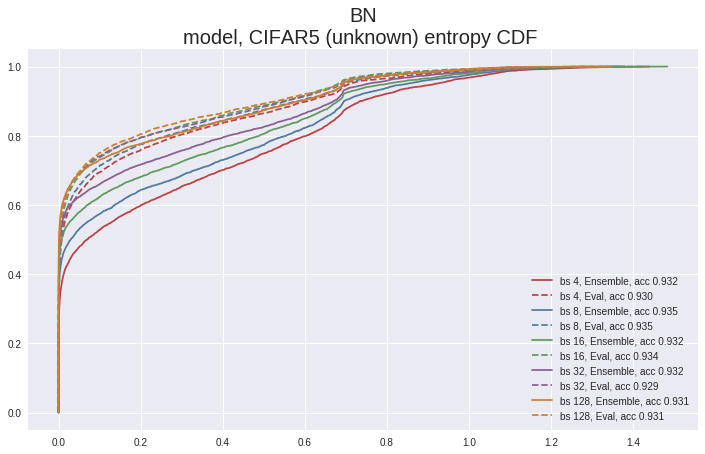

In [38]:
plt.figure(figsize=(12, 7))
plt.title('BN\nmodel, CIFAR5 (unknown) entropy CDF ', size=20)
for bs, c in zip(sorted(bn_res.keys()), colors):
    res = bn_res[bs]
    ent = res[0]['ensemble/entropy']
    n = len(ent)
    plt.plot(sorted(ent), (np.arange(n) + 1.) / n, ls='-', c=c, label='bs {}, Ensemble, acc {:.3f}'.format(bs, res[1]['ensemble/acc']))

    ent = res[0]['eval/entropy']
    n = len(ent)
    plt.plot(sorted(ent), (np.arange(n) + 1.) / n, ls='--', c=c, label='bs {}, Eval, acc {:.3f}'.format(bs, res[1]['eval/acc']))

plt.legend()

### Ensembles

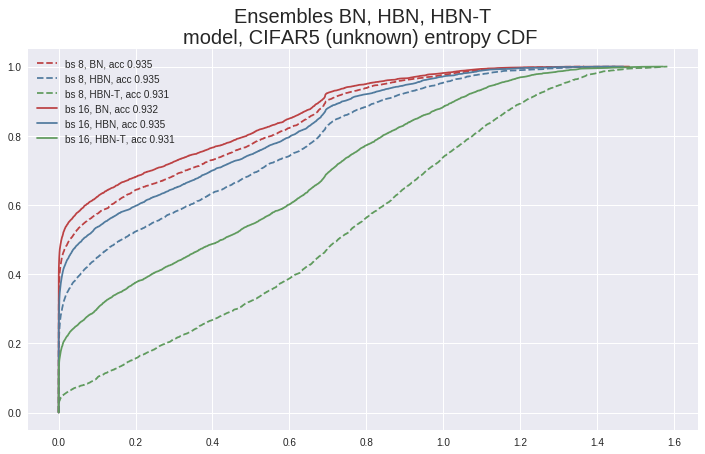

In [47]:
plt.figure(figsize=(12, 7))
plt.title('Ensembles BN, HBN, HBN-T\nmodel, CIFAR5 (unknown) entropy CDF ', size=20)
for bs, ls in zip(sorted(bn_res.keys())[1:3], ['--', '-']):
    res = bn_res[bs]
    ent = res[0]['ensemble/entropy']
    n = len(ent)
    plt.plot(sorted(ent), (np.arange(n) + 1.) / n, ls=ls, c=colors[0], label='bs {}, BN, acc {:.3f}'.format(bs, res[1]['ensemble/acc']))

    res = rbn_res[bs]
    ent = res[0]['ensemble/entropy']
    n = len(ent)
    plt.plot(sorted(ent), (np.arange(n) + 1.) / n, ls=ls, c=colors[1], label='bs {}, HBN, acc {:.3f}'.format(bs, res[1]['ensemble/acc']))

    res = hbn_res[bs]
    ent = res[0]['ensemble/entropy']
    n = len(ent)
    plt.plot(sorted(ent), (np.arange(n) + 1.) / n, ls=ls, c=colors[2], label='bs {}, HBN-T, acc {:.3f}'.format(bs, res[1]['ensemble/acc']))



plt.legend()